<a href="https://colab.research.google.com/github/Justinezgh/muse/blob/u%2FJustinezgh%2FTest_LogNormal_Lensing/notebooks/Test_Muse_LogNormal_Lensing_Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone -q https://github.com/marius311/muse-wl/
!pip install --upgrade "poetry==1.2.0b2"
!(cd muse-wl && POETRY_VIRTUALENVS_IN_PROJECT=true poetry install)
import sys, os.path as osp
sys.path = [osp.abspath("muse-wl/.venv/lib/python3.7/site-packages")] + sys.path

In [5]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches': 'tight', 'dpi': 90}

In [6]:
!pip install --quiet git+https://github.com/marius311/muse_inference.git
!pip install --quiet jax-cosmo
!pip install --quiet numpyro
!pip install --quiet dm-haiku
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/sbi_lens.git
!pip install --quiet chainconsumer

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 KB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.3/287.3 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.2/142.2 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.7/292.7 KB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.6/259.6 KB 31.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 KB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [7]:
%pylab inline

import jax
import jax.numpy as jnp
import muse_inference
from muse_inference.jax import JaxMuseProblem
from muse_inference import MuseResult
import jax_cosmo as jc

import numpyro
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist

import haiku as hk

master_seed = hk.PRNGSequence(42)

from sbi_lens.simulator import lensingLogNormal
from sbi_lens.simulator.utils import (
    get_reference_sample_posterior_full_field,
    get_reference_sample_posterior_power_spectrum
)
from chainconsumer import ChainConsumer

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/dist-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))
/usr/local/lib/python3.9/dist-packages/lenstools/utils/mpi.py:15: UserWarning: Could not import mpi4py! (if you set sys.modules['mpi4py']=None please disregard this message)
  warnings.warn(wmsg)


In [9]:
from functools import partial

model = partial(
    lensingLogNormal, 
    N=128,
    map_size=5,
    gal_per_arcmin2=30,
    sigma_e=0.2,
    model_type='lognormal',
)

In [10]:
!git clone https://github.com/DifferentiableUniverseInitiative/sbi_lens/

Cloning into 'sbi_lens'...
remote: Enumerating objects: 333, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 333 (delta 66), reused 85 (delta 37), pack-reused 169
Receiving objects: 100% (333/333), 4.33 MiB | 2.80 MiB/s, done.
Resolving deltas: 100% (150/150), done.


In [11]:
m_data = jnp.load('/content/sbi_lens/sbi_lens/data/m_data__128N_5ms_30gpa_0.2se.npy')
samples_ff = jnp.load('/content/sbi_lens/sbi_lens/data/posterior_full_field__128N_5ms_30gpa_0.2se.npy')
samples_ps = jnp.load('/content/sbi_lens/sbi_lens/data/posterior_power_spectrum__128N_5ms_30gpa_0.2se.npy')

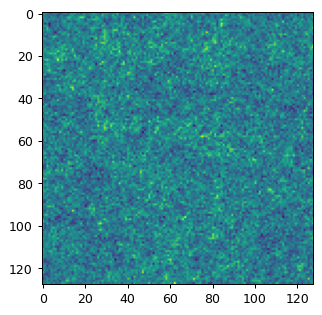

In [12]:
imshow(m_data)

In [13]:
@jax.jit
def log_likelihood(x, z, theta):
    cond_model = condition(
        model, 
        {'omega_c': theta[0], 'sigma_8': theta[1], 'y': x, 'z': z}
    )
    model_trace = trace(cond_model).get_trace()
    log_joint_like = model_trace['y']['fn'].log_prob(model_trace['y']['value']).sum()
    log_joint_like += model_trace['z']['fn'].log_prob(model_trace['z']['value']).sum()

    return log_joint_like

@jax.jit
def log_prior(theta):
    log_prob = dist.Normal(0.3, 0.05).log_prob(theta[0]) 
    log_prob += dist.Normal(0.8, 0.05).log_prob(theta[1]) 

    return log_prob

@jax.jit 
def sample_x_and_latent_var(theta, key):
    cond_model = condition(
        seed(model, key), 
        {'omega_c': theta[0], 'sigma_8': theta[1]}
    )
    model_trace = trace(cond_model).get_trace()

    return model_trace['y']['value'], model_trace['z']['value']

In [14]:
class LensingProblem(JaxMuseProblem):

    def sample_x_z(self, key, theta):
        return sample_x_and_latent_var(jnp.array(theta), key)

    def logLike(self, x, z, theta):
        return log_likelihood(x, z, jnp.array(theta))

    def logPrior(self, theta):
        return log_prior(theta)

In [15]:
prob = LensingProblem(implicit_diff=False)
prob.set_x(m_data) # fix x

/usr/local/lib/python3.9/dist-packages/jax/_src/api_util.py:240: SyntaxWarning: Jitted function has invalid argnames {'self'} in static_argnames. Function does not take these args.This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has invalid argnames {invalid_argnames} "


In [16]:
result = MuseResult()

In [17]:
theta_start = jnp.mean(samples_ps, axis = 0)
map_ff = jnp.mean(samples_ff, axis = 0)

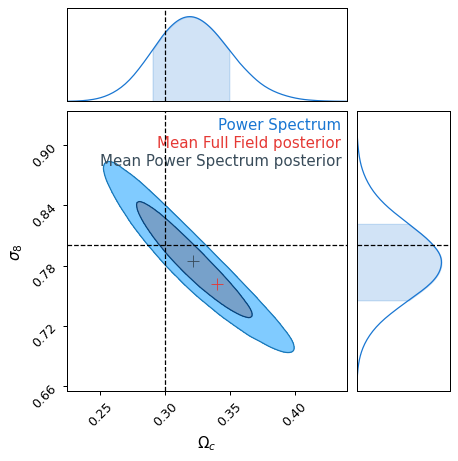

In [18]:
c = ChainConsumer()
c.add_chain(samples_ps, parameters=["$\Omega_c$", "$\sigma_8$"], name='Power Spectrum')
c.add_marker(map_ff, color='red', marker_size=100, marker_style='+', name='Mean Full Field posterior')
c.add_marker(theta_start, color='#384B59', marker_size=100, marker_style='+', name='Mean Power Spectrum posterior')
fig = c.plotter.plot(figsize="column", truth = [0.3,0.8])

In [20]:
prob.solve(
    result = result, 
    α = 0.2, 
    θ_start = theta_start, 
    θ_rtol = 0,
    z_tol = 1e-2, 
    progress = True, 
    maxsteps = 100, 
    nsims = 100,
    rng = jax.random.PRNGKey(1)
);

/usr/local/lib/python3.9/dist-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/usr/local/lib/python3.9/dist-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] - fp[ind]) / (
/usr/local/lib/python3.9/dist-packages/jax_cosmo/scipy/interpolate.py:37: UserWarnin

(0.0, 1100.3244472503661)

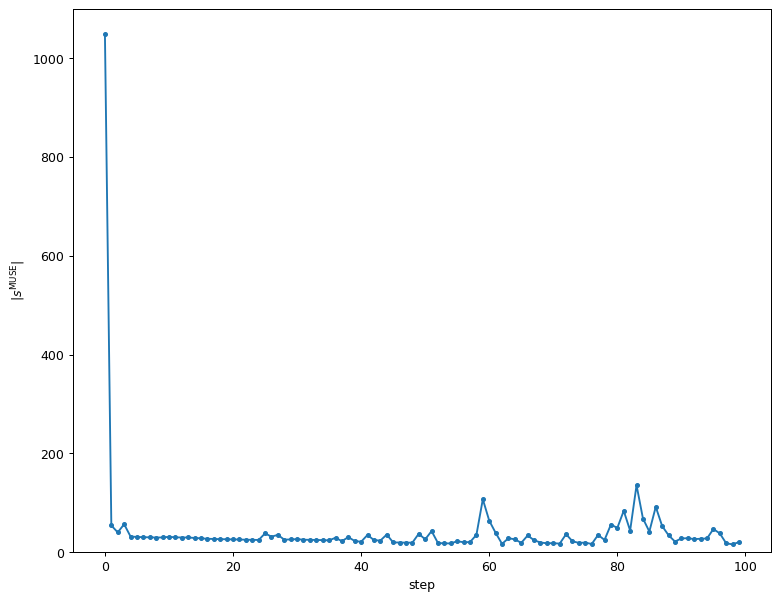

In [21]:
figure(figsize=(10,8))
plot([norm(h["s̃_post"]) for h in result.history],".-")
ylabel(r"$|s^{\rm MUSE}|$")
xlabel("step")
ylim(0)

(0.0, 141.78664741516113)

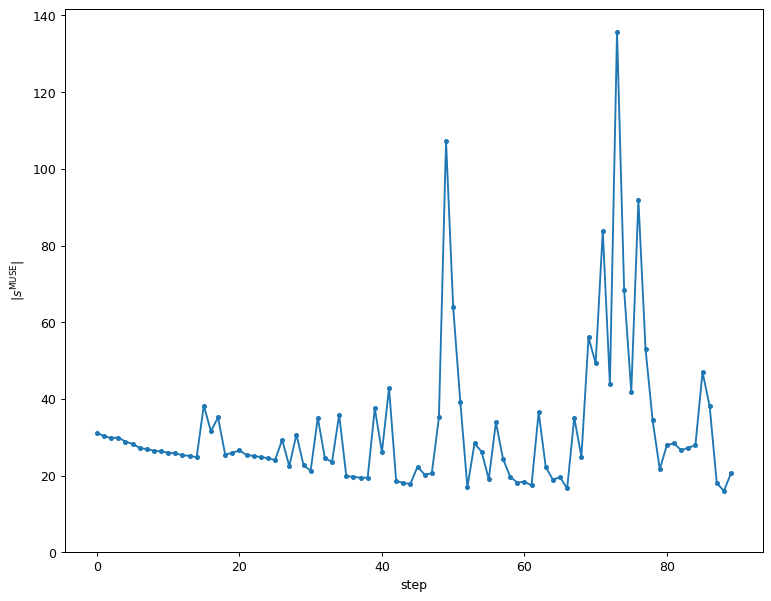

In [22]:
figure(figsize=(10,8))
plot([norm(h["s̃_post"]) for h in result.history][10:],".-")
ylabel(r"$|s^{\rm MUSE}|$")
xlabel("step")
ylim(0)

Progression of $\theta$ across steps. Should see this converge to somewhere.


Text(0.5, 1.0, 'MAP')

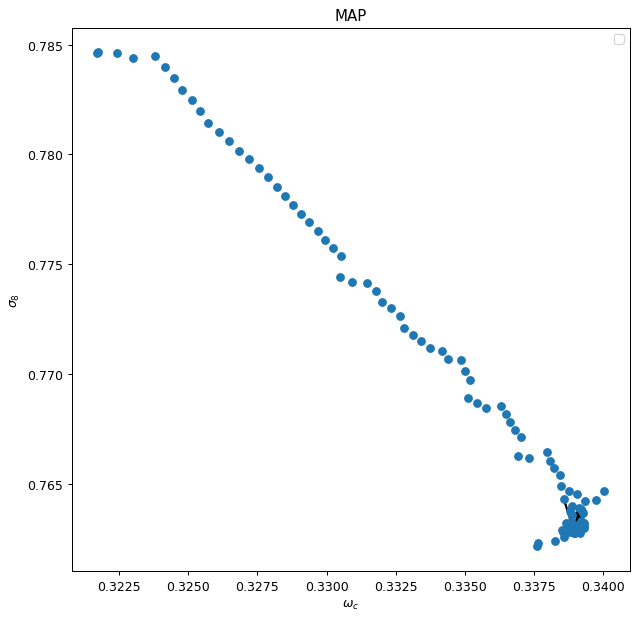

In [23]:
# https://stackoverflow.com/a/66117937
plt.figure(figsize=(8,8))
x,y = transpose([h["θ"] for h in result.history])
plt.plot(x,y,"o")
ds = 0.003
Ns = np.round(np.sqrt( (x[1:]-x[:-1])**2 + (y[1:]-y[:-1])**2 ) / ds).astype(int)
subdiv = lambda x, Ns=Ns: np.concatenate([ np.linspace(x[ii], x[ii+1], Ns[ii]) for ii, _ in enumerate(x[:-1]) ])
x, y = subdiv(x), subdiv(y)
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, width=.004, headlength=6, headwidth=6)

xlabel(r"$\omega_c$")
ylabel(r"$\sigma_8$")
legend()
title('MAP')

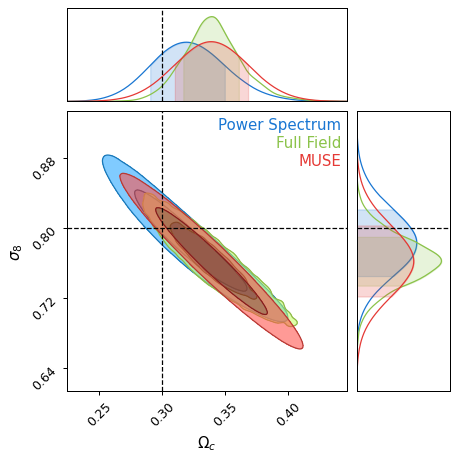

In [24]:
c = ChainConsumer()
c.add_chain(samples_ps, parameters=["$\Omega_c$", "$\sigma_8$"], name='Power Spectrum')
c.add_chain(samples_ff, parameters=["$\Omega_c$", "$\sigma_8$"], name='Full Field')
c.add_chain(result.dist.rvs(1000000), parameters=["$\Omega_c$", "$\sigma_8$"], name='MUSE')
fig = c.plotter.plot(figsize="column", truth = [0.3,0.8])